# Prolog Experiment: Tag the memory allocation and write nodes.


### The above experiment works quite well for the examples in our ilp_dataset. We believe these examples are too simplistic - therefore we are trying to add counterexamples to gain the rule we want. Following on from DG-generate-force-ILP-dataset.

We now run the progol commands below in Blue Crystal, as we need progol 4.4 compiled with GCC 5.4

We got the below in progol 4.4 (code is from this commit 011359e3)

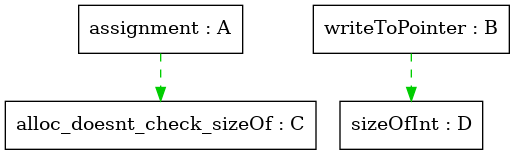

In [58]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
"""bug(A,B) :- ancestor(A,C), ancestor(B,D), assignment(A), writeToPointer(B), alloc_doesnt_check_sizeOf(C), sizeOfInt(D)."""))

Below we are trying to get a reference edge between the two subgraphs.

In [1]:
import pandas as pd
import tempfile
import subprocess
import graph_visualisation

In [4]:
ilp_data = pd.read_csv("../data/ilp_dataset_force.csv.gz")
ilp_data = ilp_data.drop("Unnamed: 0", axis=1)
ilp_data.head()

,testcase_ID,filename,code,flaw,flaw_loc,bug,code_length
0,62804,000/062/804/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,1722
1,62821,000/062/821/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,35,False,1808
2,62852,000/062/852/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,30,False,1674
3,62853,000/062/853/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2396
4,62854,000/062/854/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2414


In [6]:
prolog = pd.read_csv("../data/ilp_prolog_data_force.csv.gz")
prolog = prolog.drop("Unnamed: 0", axis=1)
prolog.head()

,testcase_ID,flaw,bug,code_length,tree,source_map
0,-8554013,CWE-121,True,1618,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_8554013_id_0, ""p1"").\n..."
1,-232086,CWE-122,True,1625,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232086_id_1, ""p2"").\ns..."
2,-232012,CWE-122,True,1619,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232012_id_1, ""p2"").\ns..."
3,-62917,CWE-121,True,1622,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62917_id_0, ""p2"").\nso..."
4,-62916,CWE-121,True,1649,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62916_id_1, ""p1"").\nso..."


In [12]:
prolog['source_code'] = ''
prolog['flaw_loc'] = 0
prolog['bad_code'] = ''

for i in range(len(prolog)):
    label = prolog.iloc[i].testcase_ID == ilp_data.testcase_ID
    prolog['source_code'].iloc[i] = ilp_data.loc[label].iloc[0].code
    prolog['flaw_loc'].iloc[i] = ilp_data.loc[label].iloc[0].flaw_loc
    
for i in range(len(prolog)):
    loc =  prolog.iloc[i].flaw_loc
    testcase_ID = prolog.iloc[i].testcase_ID
    if testcase_ID < 0:
        prolog['bad_code'].iloc[i] = prolog.iloc[i].source_code.split('\n')[loc-1].strip()[0:-1]
    else:
        prolog['bad_code'].iloc[i] = prolog.loc[prolog.testcase_ID == -testcase_ID].iloc[0].bad_code
        
good_examples = prolog[prolog['bug'] == False]
bad_examples = prolog[prolog['bug'] == True]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
def extract_node_ids(tree):
    nodes = set()
    
    in_ast_section = False
    
    for line in tree.split('\n'):
        line = line.strip()
        
        if line == '% AST':
            in_ast_section = True
        
        if line == '% CFG':
            in_ast_section = False
            
        if line == '% REF':
            in_ast_section = False
        
        if in_ast_section and not line.startswith("%"):
            parent, child = line[4:-2].split(", ")
            nodes.add(parent)
            nodes.add(child)
            
    return nodes

In [14]:
# good nodes_g
nodes_g = set()

for i in range(len(good_examples)):
    good_nodes = extract_node_ids(good_examples.iloc[i].tree)
    nodes_g = set.union(nodes_g,good_nodes)

    
# bad nodes_b
nodes_b = set()

for i in range(len(bad_examples)):
    bad_nodes = extract_node_ids(bad_examples.iloc[i].tree)
    nodes_b = set.union(nodes_b,bad_nodes)

nodes = set.union(nodes_g,nodes_b)

In [15]:
def find_bug_id(good_examples, i = 0):
    tree = good_examples.source_map.iloc[i]
    parents = []
    children = []
    in_code_section = False
    temp = 0
    for line in tree.split('\n'):
        line = line.strip()
        
        if line == '% CODE':
            in_code_section = True
        
        if in_code_section and not line.startswith("%"):
            try:
                #import pdb; pdb.set_trace()
                parent, child = line[12:-3].split(', "')
                parents.append(parent)
                children.append(child)
            except:
                temp +=1
    zipbObj = zip(children, parents)
    bug_node = dict(zipbObj)
    
    loc = good_examples.iloc[i].flaw_loc
    source_code = good_examples.iloc[i].bad_code

    return bug_node[source_code]

In [16]:
bad_node = []
good_node = []
for i in range(21):
    bad_node.append(find_bug_id(bad_examples,i))
    good_node.append(find_bug_id(good_examples,i))

In [17]:
node_and_tree = []
for node in nodes:
    start, end = node.split('_id')
    node_and_tree.append('(' +start+ ', ' +node+ ')')

node_and_tree[0:5]

['(bad_62916, bad_62916_id_27)',
 '(bad_232012, bad_232012_id_44)',
 '(bad_62867, bad_62867_id_34)',
 '(good_62917, good_62917_id_125)',
 '(good_62861, good_62861_id_203)']

In [18]:
node_tree_types = [
    'node_in_tree'+ node_tree +'.' for node_tree in node_and_tree
]

In [19]:
node_types = [
    'node('+ node_id +').' for node_id in nodes
]

In [20]:
def extract_tree_ids(tree):
    line = tree.split('\n')[2]
    line = line.strip()
    line = line.split('(')[1]
    tree_id = line.split('_id')[0]

    return tree_id

In [21]:
tree_ids = []
for tree in prolog.tree:
    tree_ids.append(extract_tree_ids(tree))

In [22]:
trees = [
    'tree('+ tree_label +').' for tree_label in tree_ids
]

In [23]:
def make_progol_script(header, positive_examples, negative_examples, testcases=None):
    script_template = """
{header}

%% Trees
{trees}

%% Types
{types}

%% background knowledge
{bg_knowledge}

%% learning task
%% positive examples
{positive_examples}

%% negative examples
{negative_examples}

    """
    script = script_template.format(
        header = header,
        trees =  '\n'.join(trees),
        types = '\n'.join(node_tree_types + node_types),
        bg_knowledge = '\n'.join(prolog['tree']),
        positive_examples='\n'.join(positive_examples),
        negative_examples='\n'.join(negative_examples),
    )
    
    # keep all testcases unless a testcases set is given in fn call
    if testcases:
        # remove all lines not related to this testcase
        script = '\n'.join([
            line for line in script.split("\n")  if any(
                str(testcase) in line for testcase in testcases
            ) or not ("good_" in line or "bad_" in line)
        ])
    
    return script

Here we try to locate the buggy nodes. For each test case this will be:
  1. Location where the memory is _allocated_.
  2. Location where the memory is _written to_.
  
We already have code above to find the latter. Can we find the first as well?

In [24]:
bad_write_nodes = bad_node
good_write_nodes = good_node

In [30]:
bad_write_nodes

['bad_8554013_id_111',
 'bad_232086_id_145',
 'bad_232012_id_145',
 'bad_62917_id_121',
 'bad_62916_id_132',
 'bad_62915_id_120',
 'bad_62913_id_128',
 'bad_62909_id_120',
 'bad_62902_id_127',
 'bad_62901_id_121',
 'bad_62900_id_120',
 'bad_62869_id_120',
 'bad_62868_id_133',
 'bad_62867_id_121',
 'bad_62865_id_127',
 'bad_62861_id_121',
 'bad_62854_id_128',
 'bad_62853_id_120',
 'bad_62852_id_121',
 'bad_62821_id_110',
 'bad_62804_id_110']

In [25]:
# this code is horrible sorry. if you need to figure out what it does speak to Dan.

alloc_source_maps = [
    line
    for source_map in prolog['source_map']
    for line in source_map.split("\n")
    if 'data =' in line.lower() and 'alloc' in line.lower()
]
bad_alloc_nodes = [
    source_map.strip("source_code(").split(",")[0]
    for source_map in alloc_source_maps
    if 'bad' in source_map
]

good_alloc_nodes = [
    source_map.strip("source_code(").split(",")[0]
    for source_map in alloc_source_maps
    if 'good' in source_map
]

positive_examples = []
for write_node in bad_write_nodes:
    # find the alloc node which has a line number before the write
    write_node_id = write_node.strip("source_code(").split(",")[0] + "_"
    write_line = int(write_node_id.split("_")[-4])
    
    testcase_id = '_'.join(write_node_id.split("_")[0:2])
    
    potential_alloc_nodes = [node for node in bad_alloc_nodes if testcase_id in node]
    for alloc_node in potential_alloc_nodes:
        alloc_node_id = alloc_node.strip("source_code(").split(",")[0] + "_"
        alloc_line = int(alloc_node_id.split("_")[-4])
        
        if alloc_line <= write_line:
            positive_examples.append(
                "bug({},{}).".format(alloc_node_id, write_node_id)
            )
            
negative_examples = []
for write_node in good_write_nodes:
    # find the alloc node which has a line number before the write
    write_node_id = write_node.strip("source_code(").split(",")[0] + "_"
    write_line = int(write_node_id.split("_")[-4])
    
    testcase_id = '_'.join(write_node_id.split("_")[0:2])
    
    potential_alloc_nodes = [node for node in good_alloc_nodes if testcase_id in node]
    for alloc_node in potential_alloc_nodes:
        alloc_node_id = alloc_node.strip("source_code(").split(",")[0] + "_"
        alloc_line = int(alloc_node_id.split("_")[-4])
        
        if alloc_line <= write_line:
            negative_examples.append(
                ":- bug({},{}).".format(alloc_node_id, write_node_id)
            )

Next we experiment with settings and different rule structures to see if it can learn a rule:

In [38]:
header = """

% Settings

%:-randomseed?
:- set(c,5000)?
:- set(i,5000)?
:- set(h,10000)?
%:- set(r,5000)?
:- set(cover)?
:- set(inflate,2000)?
%:- set(posonly)?
%:- set(memoing)?
%:- set(nodes,20000)?
%:- set(reductive)?
%:- set(splitting)?
%:- generalise(bug/20)?

% Mode declarations

:- modeh(*, bug(+node,+node))?

%:- modeb(*, same_tree(+node,+node))?
%:- modeb(*, same_tree(+node,-node))?
%:- modeb(*, same_tree(-node,+node))?
%:- modeb(*, same_tree(-node,-node))?

:- modeb(10, runs_before(+node,+node))?
%:- modeb(1, runs_before(+node,-node))?
:- modeb(2, ancestor(+node, -node))?
:- modeb(2, ancestor(-node, +node))?
%:- modeb(5, ast(+node,-node))?
%:- modeb(10, cfg(+node, -node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?
:- modeb(*, ref(+node,+node))?
%:- modeb(*, ref(-node,-node))?

:- modeb(*, assignment(+node))?
%:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

:- modeb(*, alloc_doesnt_check_sizeOf(+node))?

:- modeb(*, pointer(+node))?
:- modeb(*, sizeOfInt(+node))?
:- modeb(*, array10(+node))?
:- modeb(*, voidPointer(+node))?

writeToPointer(A) :- ast(A,B), assignment(A), compMemberAccess(B). 

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,C).

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,C).

contains_sizeOf_call(A) :- ancestor(A, B), sizeof(B).
alloc_doesnt_check_sizeOf(A) :- alloc(A), not(contains_sizeOf_call(A)).

same_tree(A,B) :- node_in_tree(T,A), node_in_tree(T,B).
"""
script = make_progol_script(
    header,
    positive_examples,
    negative_examples,
    testcases=set(ilp_data.testcase_ID) - {8554013, -8554013},
)
with open("/tmp/progol_input_force.pl", "w") as f:
    f.write(script)
!/progol/source/progol /tmp/progol_input_force.pl

CProgol Version 5.0

[:- set(c,5000)? - Time taken 0.00s]
[:- set(i,5000)? - Time taken 0.00s]
[:- set(h,10000)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,2000)? - Time taken 0.00s]
[:- modeh(100,bug(+node,+node))? - Time taken 0.00s]
[:- modeb(10,runs_before(+node,+node))? - Time taken 0.00s]
[:- modeb(2,ancestor(+node,-node))? - Time taken 0.00s]
[:- modeb(2,ancestor(-node,+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(100,alloc_doesnt_check_sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,pointer(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOfInt(+node))? - Ti

In [29]:
with open("../code/ILP-progol-input-force.pl", "w") as f:
    f.write(script)